In [1]:
import pandas as pd

from extract_transform import get_match, get_sorted_ngram_counts
from visualize import plot_ngram_counts, plot_wordcloud

In [2]:
osm_data = pd.read_json('data/preprocessed-osm-data.json.gz')
wikidata = pd.read_json('data/preprocessed-wikidata.json')

In [3]:
is_starbucks = (wikidata['qid'] == 'Q37158')
is_tim_hortons = (wikidata['qid'] == 'Q175106')
display(wikidata[is_starbucks | is_tim_hortons])

,qid,preprocessed_names,preprocessed_description
0,Q37158,starbucks starbucks corporation starbucks coff...,american multinational coffee company
5,Q175106,tim hortons tim hortons inc,multinational quick service restaurant chain


First, we start off by defining restaurants as establishments which serve food or beverages. Based on our definition we consider Starbucks and Tim Hortons as restaurants.

The Wikidata for Starbucks and Tim Hortons demonstrate that the names and descriptions for chain restaurants may not share many common words and suggest that it may be difficult to identify chain restaurants using solely their names or descriptions. This is supported by how 
1. Starbucks' description does not contain the words 'chain' or 'restaurant' while its name data  contains 'corporation' and 
2. Tim Hortons' name data contains 'inc' and its description contains 'restaurant chain'. 

This is significant as we can use wordclouds and word counts to evaluate the extent to which we can we use Wikidata names and descriptions to identify chain restaurants.

In [4]:
names = wikidata['preprocessed_names']
descriptions = wikidata['preprocessed_description']

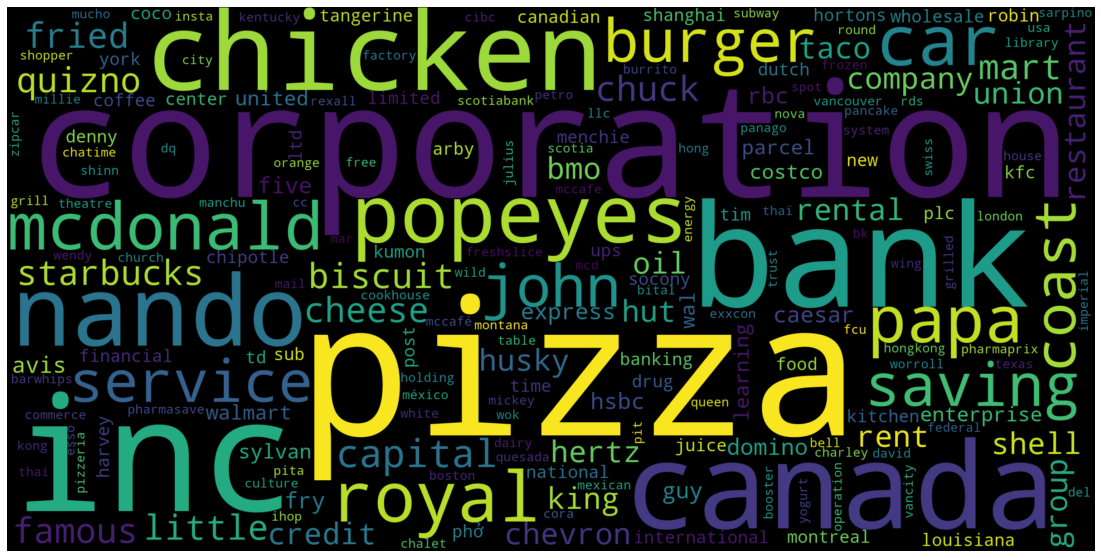

In [5]:
name_text = ' '.join(names)
plot_wordcloud(name_text)

The wordcloud uses size to represent how often a word appears. Words that appear more frequently will tend to be larger while words that appear less frequently will tend to be smaller.

This wordcloud shows that the words 'canada', 'pizza', 'inc', 'chicken', 'corporation', 'popeyes', 'bank' and 'nando' tend to appear the most frequently in Wikidata names.

It is important to note that the the size of certain words within the wordcloud for Wikidata names may be inflated due to how all name variations were scraped as shown by the Popeyes example below.

In [6]:
is_popeyes = (wikidata['qid'] == 'Q1330910')
print(list(wikidata.loc[is_popeyes, 'preprocessed_names']))

['popeyes louisiana kitchen popeyes chicken biscuit popeyes popeyes louisiana kitchen inc popeyes chicken biscuit popeyes famous fried chicken biscuit popeyes famous fried chicken biscuit popeyes famous fried chicken']


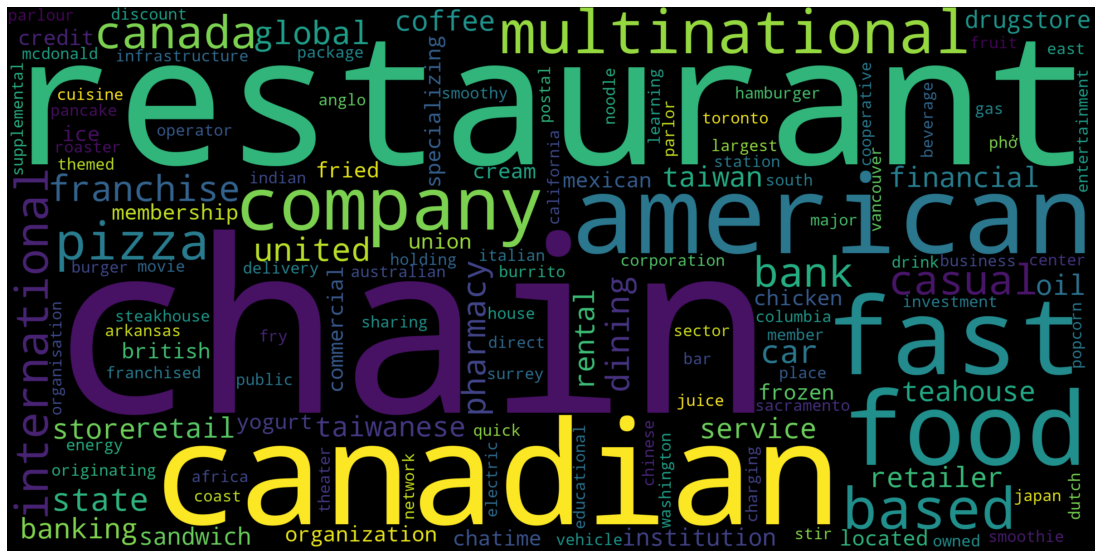

In [7]:
description_text = ' '.join(descriptions)
plot_wordcloud(description_text)

This wordcloud shows that the words 'company', 'food', 'restaurant', 'fast', 'chain', 'american', and 'canadian' tend to appear the most frequently in Wikidata descriptions.

Contrary to the wordcloud for Wikidata names, we can expect the size of the words to be more relevant since the descriptions tend to contain fewer or no repeating words.

Due to how we cannot quantify our observations from wordclouds, we first present the number of unique wikidata entries before moving on to the more quantifiable approach of counting words and pairs of adjacent words.

In [8]:
num_unique_entries = wikidata.shape[0]
print(f'Number of Unique Wikidata Entries: {num_unique_entries}')

Number of Unique Wikidata Entries: 113


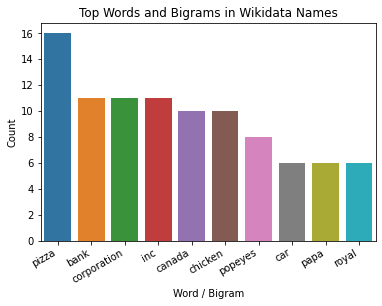

In [9]:
# find top 10 words / pairs of adjacent words using sklearn CountVectorizer
name_ngram_counts = get_sorted_ngram_counts(names, ngram_range=(1, 2))
plot_ngram_counts(
    name_ngram_counts, 
    title='Top Words and Bigrams in Wikidata Names', 
    xlabel='Word / Bigram'
)

Things to note from the histogram for Wikidata names include:
1. The most frequent occurences within Wikidata names do not include any bigrams (pairs of adjacent words) and 
2. The most frequent words and bigrams have low counts relative to the total number of wikidata entries (113) despite how some words are repeated multiple times.

This is significant as it suggests that Wikidata names may only help identify chain restaurants to a small or no extent.

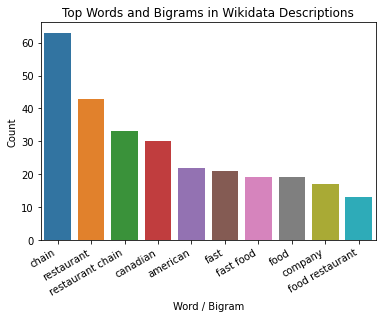

In [10]:
description_ngram_counts = get_sorted_ngram_counts(descriptions, ngram_range=(1, 2))
plot_ngram_counts(
    description_ngram_counts, 
    title='Top Words and Bigrams in Wikidata Descriptions', 
    xlabel='Word / Bigram'
)

The main thing to note from the histogram for Wikidata descriptions is that
- The words and bigrams in Wikidata descriptions have higher counts relative to the counts for Wikidata names

This is significant as it suggests that Wikidata descriptions have the potential to help identify chain restaurants to a greater extent than Wikidata names. Specifically, we may be able to identify chain restaurants based on whether their description contains the words like 'chain', and 'restaurant' or even bigrams such as 'restaurant chain'.


Finally, we can verify that the word and bigrams occur across many different wikidata descriptions as opposed to being concentrated within a select few descriptions with repeating words.

In [11]:
description_ngrams = ['chain', 'restaurant', 'restaurant chain']

for ngram in description_ngrams:
    unique_chain_matches = wikidata['preprocessed_description'].apply(
        lambda description: get_match(ngram, description)
    )
    unique_ngram_count = unique_chain_matches.notna().sum()
    print(f"Number of unique descriptions that contain '{ngram}': ", end='')
    print(unique_ngram_count)

Number of unique descriptions that contain 'chain': 63
Number of unique descriptions that contain 'restaurant': 43
Number of unique descriptions that contain 'restaurant chain': 33


This is significant as it provides additional evidence that Wikidata descriptions can help identify chain restaurants to a greater extent than Wikidata names.